# Fine Grained Image Classification

## Importing Modules and Fixing Seeds

In [1]:
!pip install torchsummary
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from PIL import Image

import torch
from torchsummary import summary
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size']=12

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Looking at The Data and Creating The Dataset For Deep Learning

In [4]:
data_dir = '../input/dog-breed-identification/'
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train'))) == len(labels))

In [5]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [7]:
X = labels.id
y = labels.breed

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.4, random_state=SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid)

In [8]:
class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return np.array(image), label

In [9]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')
        

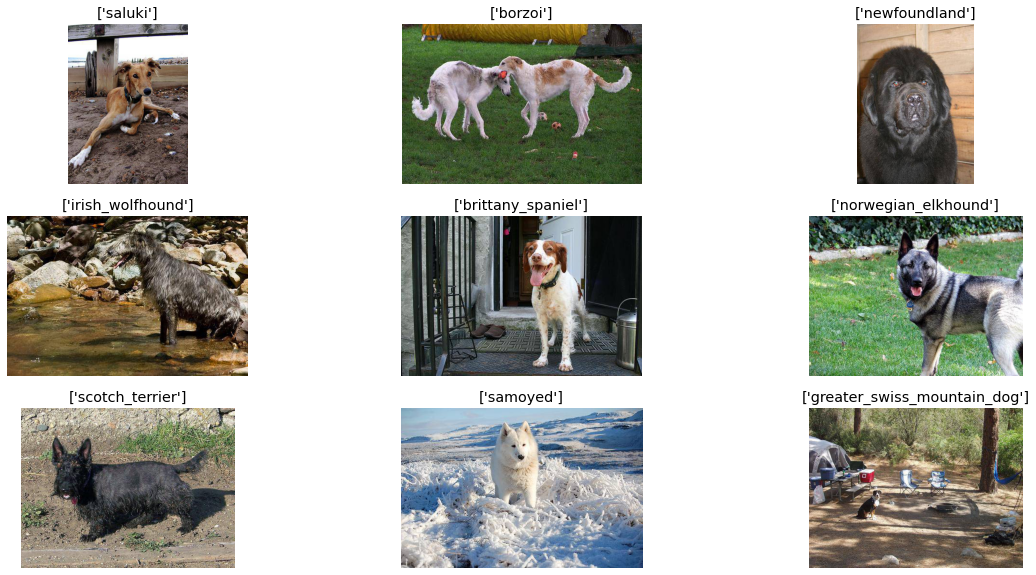

In [10]:
N_IMAGES = 9

train_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_train, labels=y_train)
images = [(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

## Getting Data Ready For Deep Learning

In [11]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
train_transforms = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.RandomGrayscale(p=0.1), 
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               normalize])

train_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_train, labels=y_train, transforms=train_transforms)
valid_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_valid, labels=y_valid, transforms=test_transforms)
test_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_test, labels=y_test, transforms=test_transforms)

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6133
Number of validation examples: 2044
Number of testing examples: 2045


In [13]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data, shuffle=True, batch_size= BATCH_SIZE)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Training on LeNet-5 From Scratch

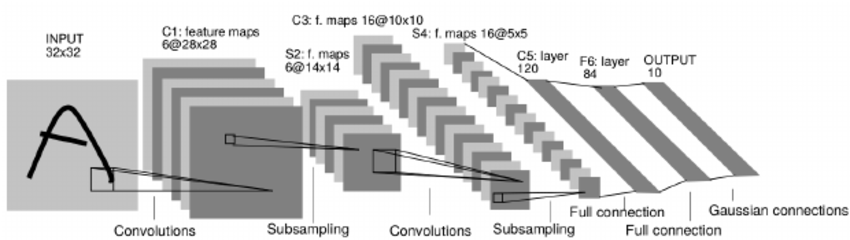

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), #stride=1, padding=0 is a default
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 120)   #num_classes = 120
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        
        return x
model = LeNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                  [-1, 120]          10,200
Total params: 71,356
Trainable params: 71,356
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model= LeNet().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer=optim.Adam(model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 71,356 trainable parameters


In [17]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = Variable(torch.FloatTensor(np.array(x))).to(device)
        y = Variable(torch.LongTensor(y)).to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = Variable(torch.FloatTensor(np.array(x))).to(device)
            y = Variable(torch.LongTensor(y)).to(device)
        
            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs):
    """ Fits a dataset to model"""
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(epochs):
    
        start_time = time.time()
    
        train_loss, train_acc = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc*100)
        valid_accs.append(valid_acc*100)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    return pd.DataFrame({f'{model_name}_Training_Loss':train_losses, 
                        f'{model_name}_Training_Acc':train_accs, 
                        f'{model_name}_Validation_Loss':valid_losses, 
                        f'{model_name}_Validation_Acc':valid_accs})

In [20]:
train_stats_LeNet = fit_model(model, 'LeNet', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=20)

Epoch: 01 | Epoch Time: 0m 50s
	Train Loss: 4.767 | Train Acc: 1.26%
	 Val. Loss: 4.672 |  Val. Acc: 1.71%
Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 4.642 | Train Acc: 2.02%
	 Val. Loss: 4.609 |  Val. Acc: 1.96%
Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 4.589 | Train Acc: 2.26%
	 Val. Loss: 4.592 |  Val. Acc: 2.69%
Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 4.563 | Train Acc: 2.77%
	 Val. Loss: 4.574 |  Val. Acc: 2.40%
Epoch: 05 | Epoch Time: 0m 35s
	Train Loss: 4.523 | Train Acc: 3.22%
	 Val. Loss: 4.568 |  Val. Acc: 2.93%
Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 4.487 | Train Acc: 3.70%
	 Val. Loss: 4.529 |  Val. Acc: 3.53%
Epoch: 07 | Epoch Time: 0m 35s
	Train Loss: 4.442 | Train Acc: 4.06%
	 Val. Loss: 4.505 |  Val. Acc: 3.82%
Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 4.391 | Train Acc: 4.34%
	 Val. Loss: 4.482 |  Val. Acc: 3.34%
Epoch: 09 | Epoch Time: 0m 35s
	Train Loss: 4.351 | Train Acc: 5.12%
	 Val. Loss: 4.469 |  Val. Acc: 3.38%
Epoch: 10 | Epoch Time: 0m 35s
	Train

In [21]:
def plot_training_statistics(train_stats, model_name):
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    axes[0].plot(train_stats[f'{model_name}_Training_Loss'], label=f'{model_name}_Training_Loss')
    axes[0].plot(train_stats[f'{model_name}_Validation_Loss'], label=f'{model_name}_Validation_Loss')
    axes[1].plot(train_stats[f'{model_name}_Training_Acc'], label=f'{model_name}_Training_Acc')
    axes[1].plot(train_stats[f'{model_name}_Validation_Acc'], label=f'{model_name}_Validation_Acc')
    
    axes[0].set_xlabel("Number of Epochs"), axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Number of Epochs"), axes[1].set_ylabel("Accuracy in %")
    
    axes[0].legend(), axes[1].legend()

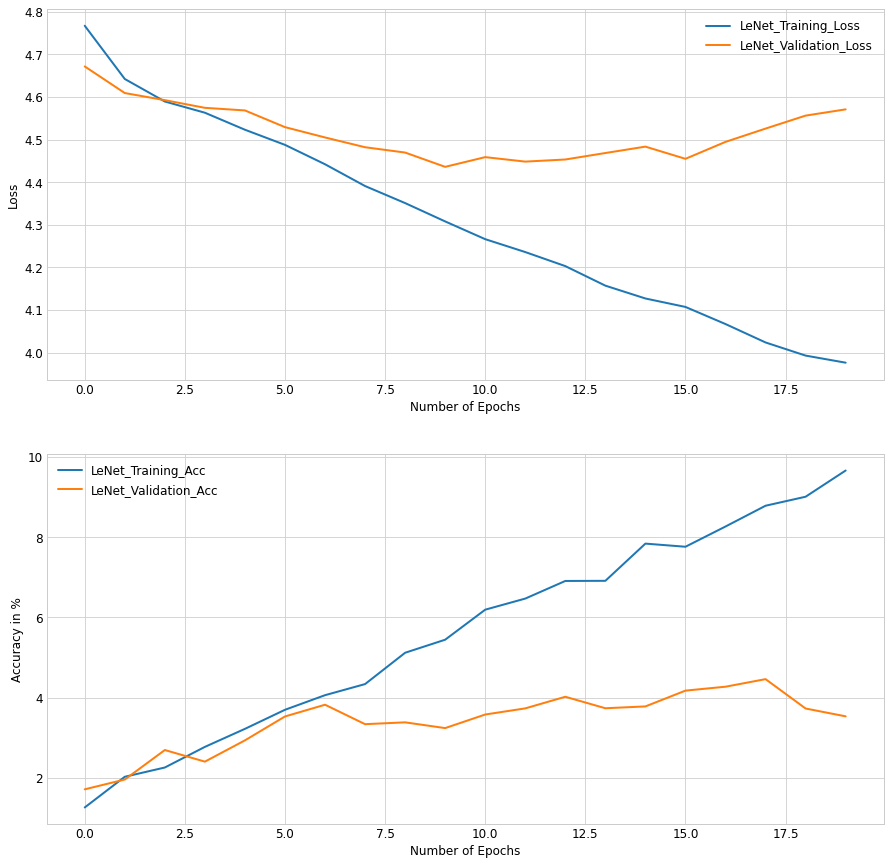

In [22]:
plot_training_statistics(train_stats_LeNet, 'LeNet')

## Training on ResNet-18 with Transfer Learning

In [23]:
from torchvision import models
model = models.resnet18(pretrained=True).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

You might not want to freeze the BatchNorm layers in a model, as they will be trained to approximate the mean and standard deviation of the dataset that the model was originally trained on, not the dataset that you want to fine-tune on. Some of the signal from your data may end up being lost as BatchNorm corrects your input. You can look at the model structure and freeze only layers that aren’t BatchNorm like this:

In [24]:
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [25]:
model.fc = nn.Linear(model.fc.in_features,120).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [26]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
train_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.RandomGrayscale(p=0.1), 
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

train_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_train, labels=y_train, transforms=train_transforms)
valid_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_valid, labels=y_valid, transforms=test_transforms)
test_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_test, labels=y_test, transforms=test_transforms)

BATCH_SIZE = 64

train_iterator = DataLoader(train_data, shuffle=True, batch_size= BATCH_SIZE)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE)

In [27]:
train_stats_ResNet18 = fit_model(model, 'ResNet18', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=20)

Epoch: 01 | Epoch Time: 1m 5s
	Train Loss: 3.353 | Train Acc: 28.98%
	 Val. Loss: 1.810 |  Val. Acc: 50.21%
Epoch: 02 | Epoch Time: 1m 5s
	Train Loss: 1.859 | Train Acc: 47.84%
	 Val. Loss: 1.770 |  Val. Acc: 50.94%
Epoch: 03 | Epoch Time: 1m 5s
	Train Loss: 1.554 | Train Acc: 56.36%
	 Val. Loss: 1.569 |  Val. Acc: 56.50%
Epoch: 04 | Epoch Time: 1m 5s
	Train Loss: 1.390 | Train Acc: 60.13%
	 Val. Loss: 1.643 |  Val. Acc: 54.50%
Epoch: 05 | Epoch Time: 1m 5s
	Train Loss: 1.305 | Train Acc: 61.62%
	 Val. Loss: 1.354 |  Val. Acc: 62.72%
Epoch: 06 | Epoch Time: 1m 5s
	Train Loss: 1.220 | Train Acc: 63.95%
	 Val. Loss: 1.458 |  Val. Acc: 59.26%
Epoch: 07 | Epoch Time: 1m 5s
	Train Loss: 1.121 | Train Acc: 66.39%
	 Val. Loss: 1.384 |  Val. Acc: 63.11%
Epoch: 08 | Epoch Time: 1m 5s
	Train Loss: 1.076 | Train Acc: 67.53%
	 Val. Loss: 1.464 |  Val. Acc: 59.93%
Epoch: 09 | Epoch Time: 1m 5s
	Train Loss: 1.034 | Train Acc: 68.37%
	 Val. Loss: 1.358 |  Val. Acc: 62.52%
Epoch: 10 | Epoch Time: 1m 5

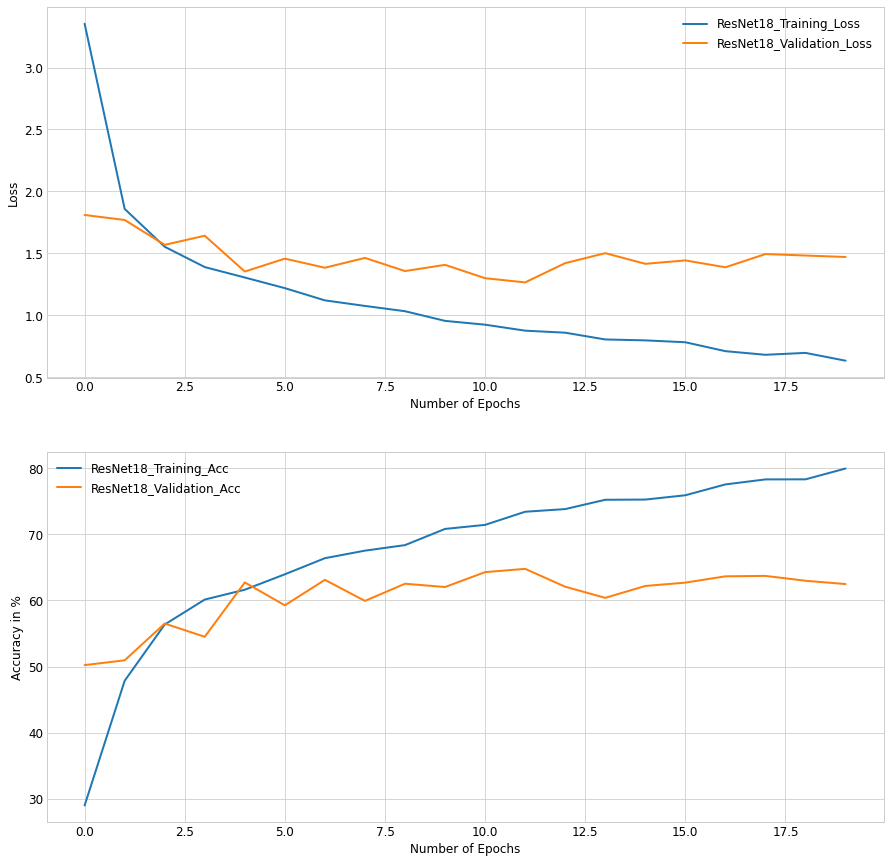

In [28]:
plot_training_statistics(train_stats_ResNet18, 'ResNet18')

## Training on ResNet-34 with Transfer Learning

In [29]:
from torchvision import models
model = models.resnet34(pretrained=True).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [30]:
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [31]:
model.fc = nn.Linear(model.fc.in_features,120).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [32]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
train_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.RandomGrayscale(p=0.1), 
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

train_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_train, labels=y_train, transforms=train_transforms)
valid_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_valid, labels=y_valid, transforms=test_transforms)
test_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_test, labels=y_test, transforms=test_transforms)

BATCH_SIZE = 64

train_iterator = DataLoader(train_data, shuffle=True, batch_size= BATCH_SIZE)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE)

In [33]:
train_stats_ResNet34 = fit_model(model, 'ResNet34', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=20)

Epoch: 01 | Epoch Time: 1m 16s
	Train Loss: 3.127 | Train Acc: 32.35%
	 Val. Loss: 1.819 |  Val. Acc: 50.55%
Epoch: 02 | Epoch Time: 1m 17s
	Train Loss: 1.729 | Train Acc: 51.90%
	 Val. Loss: 1.405 |  Val. Acc: 59.39%
Epoch: 03 | Epoch Time: 1m 16s
	Train Loss: 1.474 | Train Acc: 58.02%
	 Val. Loss: 1.309 |  Val. Acc: 61.72%
Epoch: 04 | Epoch Time: 1m 16s
	Train Loss: 1.279 | Train Acc: 62.36%
	 Val. Loss: 1.342 |  Val. Acc: 60.54%
Epoch: 05 | Epoch Time: 1m 16s
	Train Loss: 1.212 | Train Acc: 64.18%
	 Val. Loss: 1.454 |  Val. Acc: 59.70%
Epoch: 06 | Epoch Time: 1m 16s
	Train Loss: 1.089 | Train Acc: 67.64%
	 Val. Loss: 1.640 |  Val. Acc: 58.71%
Epoch: 07 | Epoch Time: 1m 15s
	Train Loss: 1.064 | Train Acc: 66.98%
	 Val. Loss: 1.393 |  Val. Acc: 62.72%
Epoch: 08 | Epoch Time: 1m 15s
	Train Loss: 0.971 | Train Acc: 70.34%
	 Val. Loss: 1.237 |  Val. Acc: 65.65%
Epoch: 09 | Epoch Time: 1m 16s
	Train Loss: 0.910 | Train Acc: 72.19%
	 Val. Loss: 1.205 |  Val. Acc: 66.20%
Epoch: 10 | Epoch T

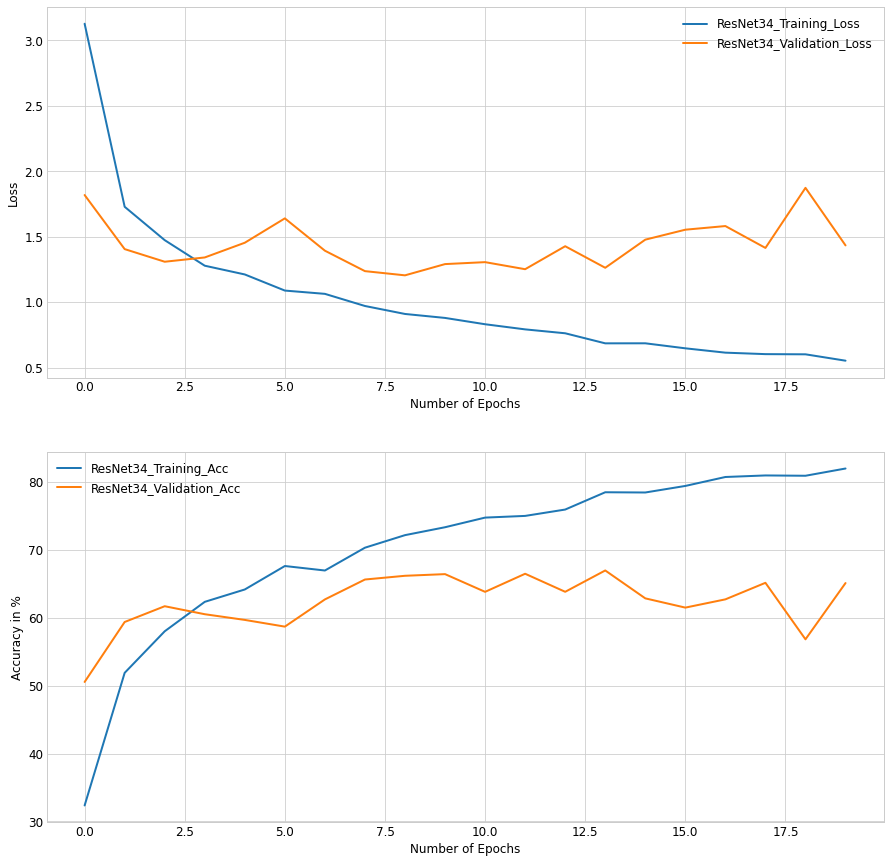

In [34]:
plot_training_statistics(train_stats_ResNet34, 'ResNet34')